In [1]:
using PyPlot
using JLD

include("../src/PDMP.jl")
using PDMP
using Klara

# Global PDMP -- gaussians
---

In [45]:
function compareGaussian(path, mvg, d1, d2)
    P1  = mvg.prec
    mu  = mvg.mu
    C1  = inv(P1)
    C1s = C1[[d1,d2],[d1,d2]]

    mu1, mu2 = mu[d1], mu[d2]
    s1,  s2  = sqrt(C1[d1,d1]), sqrt(C1[d2,d2])
    
    npts     = 250

    x1min, x1max = mu1 + 2*[-s1,s1]
    x2min, x2max = mu2 + 2*[-s2,s2]

    ss = 500

    Tp = path.ts[end] - 0.001 # FIXME (hack)
    gt = linspace(0,Tp,ss)
    xx = [PDMP.samplepath(path,t)[d1] for t in gt]
    yy = [PDMP.samplepath(path,t)[d2] for t in gt]

    # -----------------
    # Building the grid

    ng = 50 
    x  = linspace(x1min, x1max, ng)
    y  = linspace(x2min, x2max, ng)

    xgrid = repmat(x', ng, 1)
    ygrid = repmat(y, 1, ng)

    z = zeros(ng,ng)
    for i in 1:ng, j in 1:ng
        z[i,j] = exp(-dot([x[i],y[j]]-[mu1,mu2],inv(C1s)*([x[i],y[j]]-[mu1,mu2])))
    end

    # --------------
    # Contour + path

    contour(xgrid,ygrid,z)
    plot(xx,yy, ".")

end
;

## BPS1 - Multivariate Gaussian (10dim)
---

`ex_bps_mvg1.jl`


In [18]:
d = load("res/dex_bps_mvg1.jld")

path    = d["path"]
mvg     = d["mvg"]
details = d["details"]

Dict{String,Any} with 7 entries:
  "nboundary" => 0
  "nsegments" => 14964
  "clocktime" => 0.458104
  "nloops"    => 14963
  "nbounce"   => 10000
  "ngradeval" => 10000
  "nrefresh"  => 4963

In [19]:
ss    = 10000
Tp    = path.ts[end] - 0.001 # FIXME (hack)
gg    = linspace(0,Tp,ss)
muest = sum(PDMP.samplepath(path,t) for t in gg) / ss

mu = mvg.mu
p  = length(mvg.mu)

println("MSE on mu:", norm(muest-mu)/p)

MSE on mu:0.01659835559951217


### ESS

In [20]:
ess = [Klara.ess([PDMP.samplepath(path,t)[i] for t in gg]) for i in 1:p]

esscpu = ess/details["clocktime"]

min_, mini_ = findmin(ess)
max_, maxi_ = findmax(ess)

println("Min ESS, dim$mini_ :: $(round(min_,2)) -- per CPUsec: $(round(esscpu[mini_],2))")
println("Max ESS, dim$maxi_ :: $(round(max_,2)) -- per CPUsec: $(round(esscpu[maxi_],2))")

Min ESS, dim4 :: 39.17 -- per CPUsec: 85.52
Max ESS, dim3 :: 268.53 -- per CPUsec: 586.17


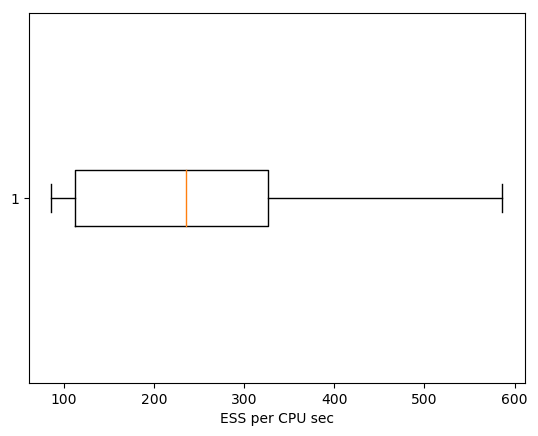

In [21]:
boxplot(esscpu,0, "rs", 0)
xlabel("ESS per CPU sec")
;

### Further visualisations

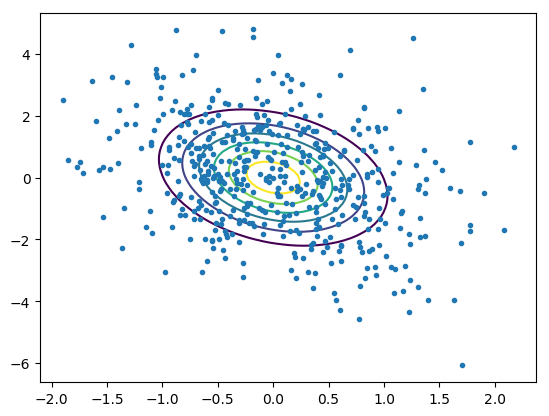

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x321fc4290>

In [33]:
compareGaussian(path, mvg, 3, 4)

## BPS2 - Multivariate Gaussian (3dim), high correl
---

`ex_bps_mvg2.jl`


In [9]:
d = load("res/dex_bps_mvg2.jld")

path    = d["path"]
mvg     = d["mvg"]
details = d["details"]

Dict{String,Any} with 7 entries:
  "nboundary" => 0
  "nsegments" => 20873
  "clocktime" => 0.414277
  "nloops"    => 20872
  "nbounce"   => 10000
  "ngradeval" => 10000
  "nrefresh"  => 10872

In [10]:
ss    = 10000
Tp    = path.ts[end] - 0.001 # FIXME (hack)
gg    = linspace(0,Tp,ss)
muest = sum(PDMP.samplepath(path,t) for t in gg) / ss

mu = mvg.mu
p  = length(mvg.mu)

println("MSE on mu:", norm(muest-mu)/p)

MSE on mu:0.26519954620853187


### ESS

In [11]:
ess = [Klara.ess([PDMP.samplepath(path,t)[i] for t in gg]) for i in 1:p]

esscpu = ess/details["clocktime"]

min_, mini_ = findmin(ess)
max_, maxi_ = findmax(ess)

println("Min ESS, dim$mini_ :: $(round(min_,2)) -- per CPUsec: $(round(esscpu[mini_],2))")
println("Max ESS, dim$maxi_ :: $(round(max_,2)) -- per CPUsec: $(round(esscpu[maxi_],2))")

Min ESS, dim3 :: 60.8 -- per CPUsec: 146.75
Max ESS, dim1 :: 110.14 -- per CPUsec: 265.86


In [13]:
esscpu

3-element Array{Float64,1}:
 265.862
 146.847
 146.751

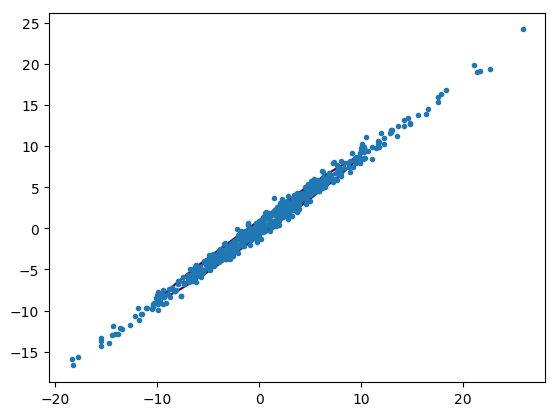

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3223c3ad0>

In [17]:
compareGaussian(path, mvg, 2, 3)

## BPS3 - Truncated multivariate gaussian
---

`ex_bps_mvg3.jl`


In [35]:
d = load("res/dex_bps_mvg3.jld")

path    = d["path"]
mvg     = d["mvg"]
details = d["details"]
mtrunc  = d["trunc_mean"]

2-element Array{Float64,1}:
 1.34427 
 0.936328

In [38]:
ss    = 10000
Tp    = path.ts[end] - 0.001 
gg    = linspace(0,Tp,ss)
muest = sum(PDMP.samplepath(path,t) for t in gg) / ss

p  = length(mtrunc)

println("MSE on mu:", norm(muest-mtrunc)/p)

MSE on mu:0.013153807673741238


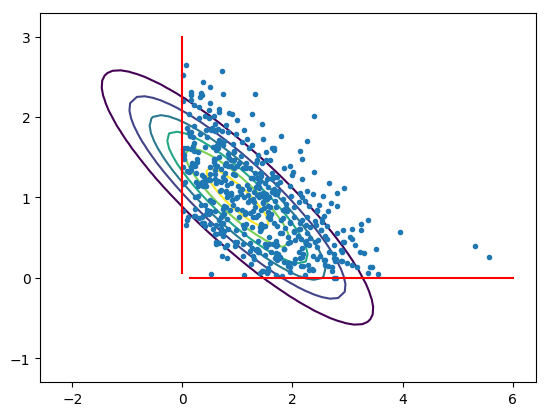

In [54]:
compareGaussian(path, mvg, 1, 2)
x = linspace(-1.,6.,50)
y = linspace(-1.,3.,50)
plot(x[x.>0.],   x[x.>0.]*0., "-r")
plot(y[y.>0.]*0, y[y.>0.],    "-r" )
;

# Global PDMP -- logistic regression
---

In [59]:
d = load("res/dex_bps_logreg1.jld")

path    = d["path"]
dm      = d["dm"]
details = d["details"]
w       = d["w"]
;

In [61]:
ss   = 10000
Tp   = path.ts[end] - 0.001 # FIXME (hack)
gg   = linspace(0,Tp,ss)
west = sum(PDMP.samplepath(path,t) for t in gg) / ss

println("Rel bias on param:", norm(west-w)/norm(w))

Rel bias on param:0.03175567803366873


In [63]:
ess = [Klara.ess([PDMP.samplepath(path,t)[i] for t in gg]) for i in 1:dm.p]

min_, mini_ = findmin(ess)
max_, maxi_ = findmax(ess)

println("Min ESS, dim$mini_ :: $(round(min_,2))")
println("Max ESS, dim$maxi_ :: $(round(max_,2))")

Min ESS, dim34 :: 3.74
Max ESS, dim11 :: 33.55
